In [ ]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
from shapely.geometry import MultiPoint
from scipy.spatial import ConvexHull

# Load cleaned data
df_cleaned = pd.read_csv("cleaned_uber_data.csv")

# Compare dataset sizes
original_size = df.shape[0]  # Original dataset rows
cleaned_size = df_cleaned.shape[0]  # Cleaned dataset rows
removed_records = original_size - cleaned_size  # Calculate removed rows

print(f"Original dataset size: {original_size} rows")
print(f"Cleaned dataset size: {cleaned_size} rows")
print(f"Total records removed: {removed_records} rows")


# Extract pickup locations
pickup_points = df_cleaned[['pickup_longitude', 'pickup_latitude']].values

# Apply K-Means Clustering
num_clusters = 5  # Adjust based on dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(pickup_points)
df_cleaned['cluster'] = labels

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

# Create a Folium map
map_center = [np.mean(pickup_points[:, 1]), np.mean(pickup_points[:, 0])]
m = folium.Map(location=map_center, zoom_start=12)

# Add clustered data points to the map
marker_cluster = MarkerCluster().add_to(m)
for point, label in zip(pickup_points, labels):
    folium.CircleMarker(
        location=[point[1], point[0]],
        radius=3,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.6,
        popup=f"Cluster {label}"
    ).add_to(marker_cluster)

# Generate Convex Hull Polygons for Each Cluster
cluster_colors = ["red", "green", "blue", "purple", "orange"]  # Define colors for clusters

for cluster_label in range(num_clusters):
    cluster_points = pickup_points[labels == cluster_label]  # Get points for each cluster

    if len(cluster_points) >= 3:  # Convex hull requires at least 3 points
        hull = ConvexHull(cluster_points)  # Compute convex hull
        polygon_coords = [(cluster_points[i][1], cluster_points[i][0]) for i in hull.vertices]  # Lat/Lon order

        folium.Polygon(
            locations=polygon_coords,
            color=cluster_colors[cluster_label % len(cluster_colors)],
            fill=True,
            fill_color=cluster_colors[cluster_label % len(cluster_colors)],
            fill_opacity=0.3,
            popup=f"Cluster {cluster_label} Polygon"
        ).add_to(m)

# Save map to an HTML file
m.save("fixed_taxi_clusters.html")
print("Map saved as fixed_taxi_clusters.html. Open it in a browser to view.")


Map saved as fixed_taxi_clusters.html. Open it in a browser to view.


Original dataset size: 200000 rows
Cleaned dataset size: 182102 rows
Total records removed: 17898 rows
Variance:
 fare_amount        35.499166
passenger_count     1.702638
dtype: float64

Standard Deviation:
 fare_amount        5.958118
passenger_count    1.304852
dtype: float64


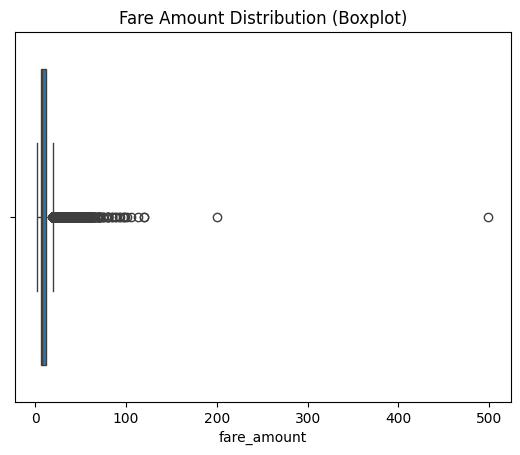

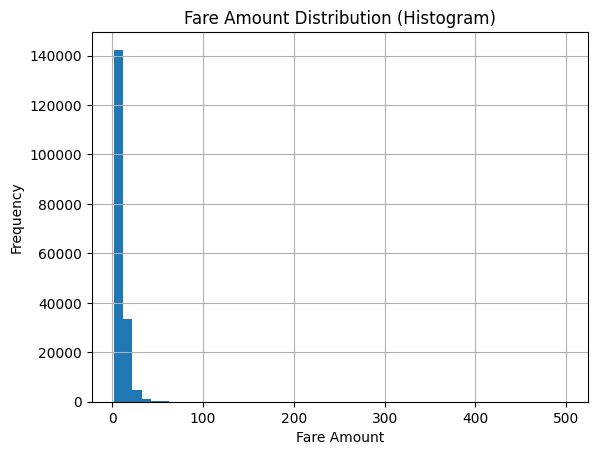

Map saved as fixed_taxi_clusters.html. Open it in a browser to view.


In [ ]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap, MarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
from shapely.geometry import MultiPoint
from scipy.stats import zscore

# --- STEP 1: Load Dataset ---
df = pd.read_csv("uber.csv", header=0)

# Store original dataset size
original_size = df.shape[0]

# --- STEP 2: Fix Pickup Datetime Column ---
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df = df.dropna(subset=['pickup_datetime'])  # Remove rows where conversion failed

# --- STEP 3: Remove NaNs ---
df = df.dropna()

# --- STEP 4: Remove Zero Values in Critical Columns ---
zero_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
df = df[~(df[zero_cols] == 0).any(axis=1)]

# --- STEP 5: Apply NYC Geographic Boundaries ---
nyc_bounds = {
    "long_min": -74.3, "long_max": -73.7,
    "lat_min": 40.5, "lat_max": 40.9
}

df = df[
    (df['pickup_longitude'].between(nyc_bounds["long_min"], nyc_bounds["long_max"])) &
    (df['pickup_latitude'].between(nyc_bounds["lat_min"], nyc_bounds["lat_max"])) &
    (df['dropoff_longitude'].between(nyc_bounds["long_min"], nyc_bounds["long_max"])) &
    (df['dropoff_latitude'].between(nyc_bounds["lat_min"], nyc_bounds["lat_max"]))
]

# --- STEP 6: Remove Unrealistic Fare Amounts ---
df['fare_amount'] = pd.to_numeric(df['fare_amount'], errors='coerce')
df = df[(df['fare_amount'] > 1) & (df['fare_amount'] < 500)]  # Typical NYC fare range

# --- STEP 7: Validate Passenger Count ---
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]  # Most taxis allow 1-6 passengers

# --- STEP 8: Outlier Removal Using Z-score ---
geo_cols = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
z_scores = np.abs(df[geo_cols].apply(zscore))  # Compute Z-score for each row
df = df[(z_scores < 3).all(axis=1)]  # Remove rows with Z-score > 3 (outliers)

# Store cleaned dataset size
cleaned_size = df.shape[0]
records_removed = original_size - cleaned_size

# --- STEP 9: Feature Extraction ---
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month

# --- STEP 10: Save Cleaned Data ---
df.to_csv("cleaned_uber_data.csv", index=False)

# Print dataset difference
print(f"Original dataset size: {original_size} rows")
print(f"Cleaned dataset size: {cleaned_size} rows")
print(f"Total records removed: {records_removed} rows")

# --- STEP 11: Data Visualization ---
# Variance & Standard Deviation
cols = ["fare_amount", "passenger_count"]
print("Variance:\n", df[cols].var())
print("\nStandard Deviation:\n", df[cols].std())

# Fare Amount Distribution
sns.boxplot(x=df["fare_amount"])
plt.title("Fare Amount Distribution (Boxplot)")
plt.show()

df["fare_amount"].hist(bins=50)
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.title("Fare Amount Distribution (Histogram)")
plt.show()

# --- STEP 12: Geospatial Heatmap ---
m = folium.Map(location=[40.7, -74.0], zoom_start=12)
heat_data = list(zip(df["pickup_latitude"], df["pickup_longitude"]))
HeatMap(heat_data, radius=10).add_to(m)
m.save("heatmap_pickup_distribution.html")

# --- STEP 13: K-Means Clustering with More Clusters ---
pickup_points = df[['pickup_longitude', 'pickup_latitude']].values
num_clusters = min(10, max(3, len(pickup_points) // 5000))  # Dynamic cluster count

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(pickup_points)

df['cluster'] = labels
cluster_centers = kmeans.cluster_centers_

# Create a Folium Map for Clusters
map_center = [np.mean(pickup_points[:, 1]), np.mean(pickup_points[:, 0])]
m = folium.Map(location=map_center, zoom_start=12)
marker_cluster = MarkerCluster().add_to(m)

# Add Data Points to Map
for point, label in zip(pickup_points, labels):
    folium.CircleMarker(
        location=[point[1], point[0]],
        radius=3,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.6,
        popup=f"Cluster {label}"
    ).add_to(marker_cluster)

# Generate Convex Hull Polygons for Each Cluster
cluster_colors = ["red", "green", "blue", "purple", "orange", "yellow", "cyan", "magenta"]

for cluster_label in range(num_clusters):
    cluster_points = pickup_points[labels == cluster_label]  # Get points for each cluster

    if len(cluster_points) >= 3:  # Convex hull requires at least 3 points
        hull = ConvexHull(cluster_points)  # Compute convex hull
        polygon_coords = [(cluster_points[i][1], cluster_points[i][0]) for i in hull.vertices]  # Lat/Lon order

        folium.Polygon(
            locations=polygon_coords,
            color=cluster_colors[cluster_label % len(cluster_colors)],
            fill=True,
            fill_color=cluster_colors[cluster_label % len(cluster_colors)],
            fill_opacity=0.3,
            popup=f"Cluster {cluster_label} Polygon"
        ).add_to(m)

# Save map to an HTML file
m.save("fixed_taxi_clusters.html")
print("Map saved as fixed_taxi_clusters.html. Open it in a browser to view.")



<ipython-input-3-ca7ce100bb9b>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['fare_amount'] = pd.to_numeric(df_cleaned['fare_amount'], errors='coerce')


Original dataset size: 200000 rows
Cleaned dataset size: 171208 rows
Total records removed: 28792 rows


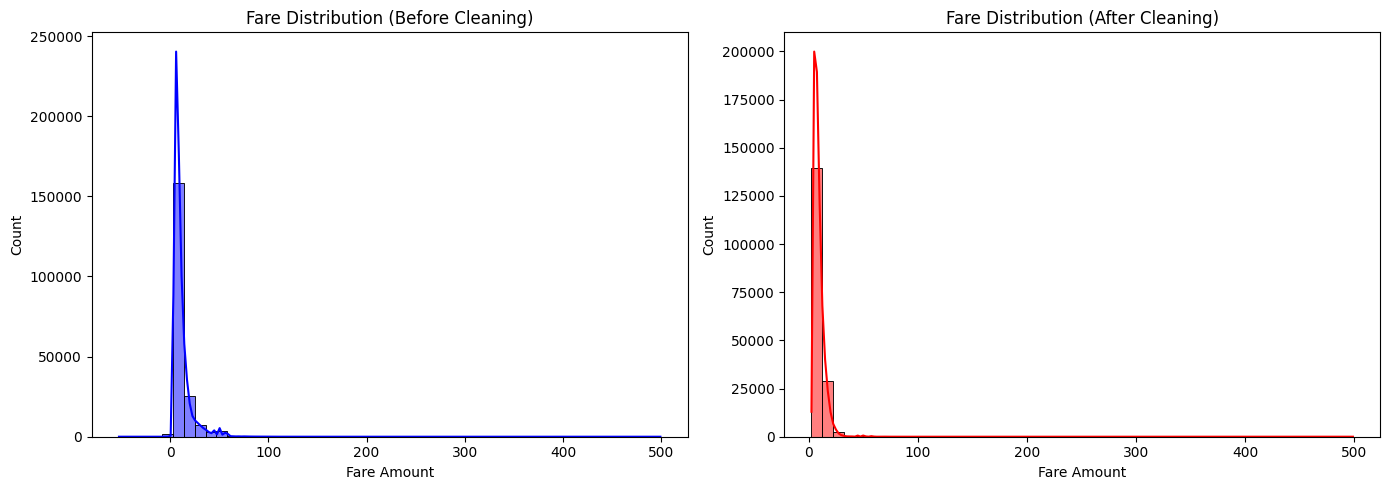

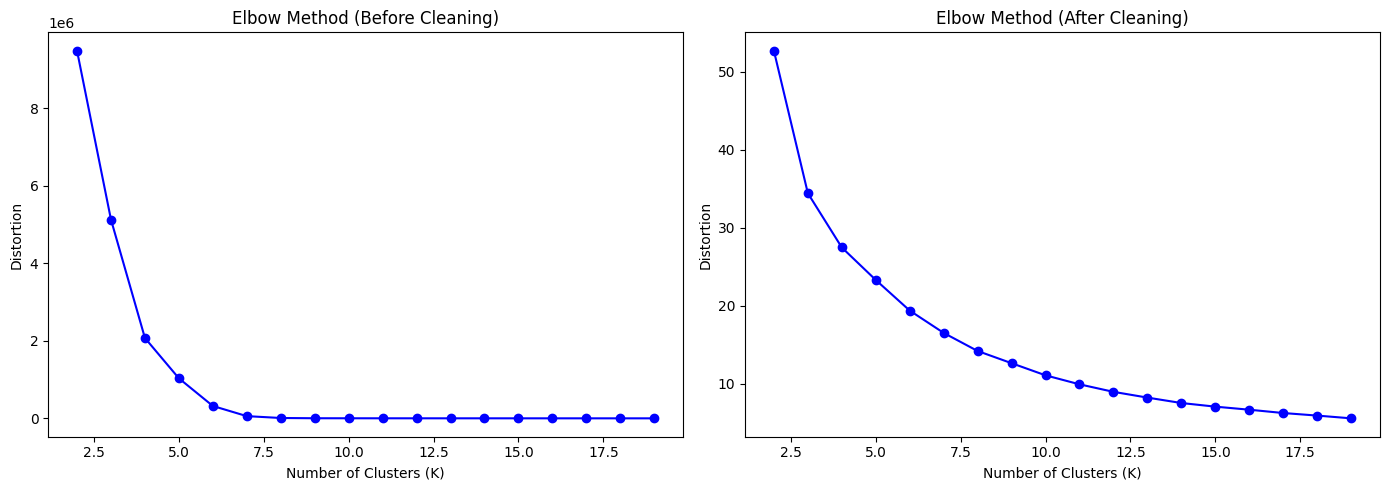

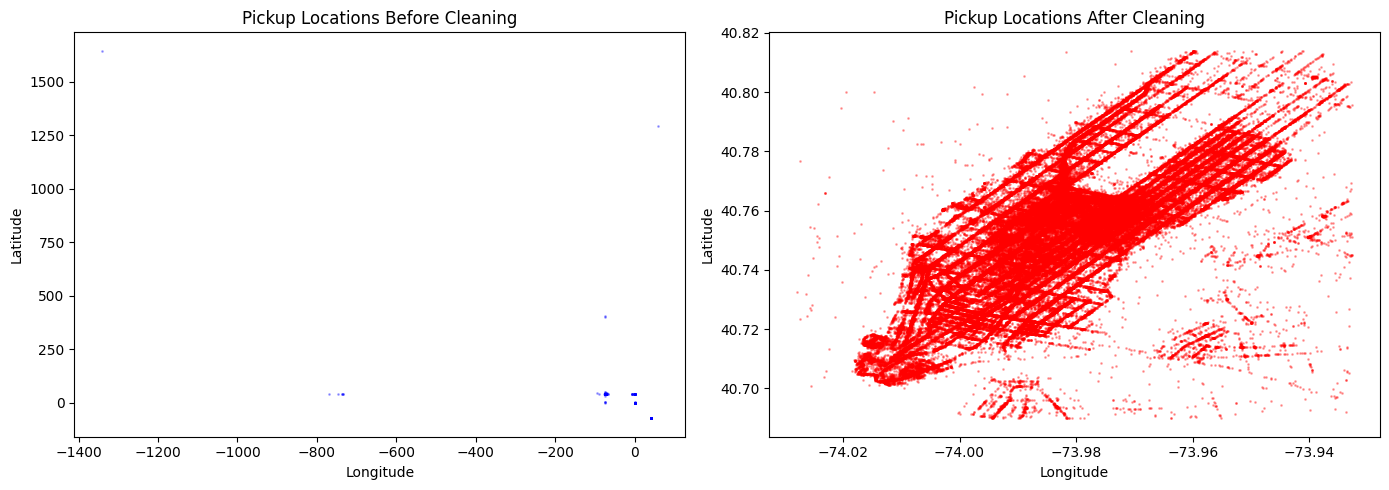

Cluster Map saved as taxi_clusters_map.html


In [3]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap, MarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from shapely.geometry import MultiPoint
from scipy.spatial import ConvexHull
from scipy.stats import norm

# Load dataset
df_original = pd.read_csv("uber.csv", header=0)

# --- STEP 1: Fix Pickup Datetime Column ---
df_original['pickup_datetime'] = pd.to_datetime(df_original['pickup_datetime'], errors='coerce')

# Drop rows where pickup_datetime conversion failed
df_cleaned = df_original.dropna(subset=['pickup_datetime'])

# --- STEP 2: Remove NaNs ---
df_cleaned = df_cleaned.dropna()

# --- STEP 3: Remove Rows with Zero Values for Critical Columns ---
zero_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
df_cleaned = df_cleaned[~(df_cleaned[zero_cols] == 0).any(axis=1)]

# --- STEP 4: Apply Geographic Boundaries (NYC region) ---
nyc_bounds = {"long_min": -74.3, "long_max": -73.7, "lat_min": 40.5, "lat_max": 40.9}

df_cleaned = df_cleaned[
    (df_cleaned['pickup_longitude'].between(nyc_bounds["long_min"], nyc_bounds["long_max"])) &
    (df_cleaned['pickup_latitude'].between(nyc_bounds["lat_min"], nyc_bounds["lat_max"])) &
    (df_cleaned['dropoff_longitude'].between(nyc_bounds["long_min"], nyc_bounds["long_max"])) &
    (df_cleaned['dropoff_latitude'].between(nyc_bounds["lat_min"], nyc_bounds["lat_max"]))
]

# --- STEP 5: Remove Unrealistic Fare Amounts ---
df_cleaned['fare_amount'] = pd.to_numeric(df_cleaned['fare_amount'], errors='coerce')
df_cleaned = df_cleaned[(df_cleaned['fare_amount'] > 1) & (df_cleaned['fare_amount'] < 500)]

# --- STEP 6: Validate Passenger Count ---
df_cleaned = df_cleaned[(df_cleaned['passenger_count'] > 0) & (df_cleaned['passenger_count'] <= 6)]

# --- STEP 7: Outlier Removal Using IQR ---
geo_cols = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
Q1 = df_cleaned[geo_cols].quantile(0.25)
Q3 = df_cleaned[geo_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned = df_cleaned[~((df_cleaned[geo_cols] < lower_bound) | (df_cleaned[geo_cols] > upper_bound)).any(axis=1)]

# --- STEP 8: Feature Extraction ---
df_cleaned['hour'] = df_cleaned['pickup_datetime'].dt.hour
df_cleaned['day_of_week'] = df_cleaned['pickup_datetime'].dt.dayofweek
df_cleaned['month'] = df_cleaned['pickup_datetime'].dt.month

# --- STEP 9: Save Cleaned Data ---
df_cleaned.to_csv("cleaned_uber_data.csv", index=False)

# Compare dataset sizes
original_size = df_original.shape[0]
cleaned_size = df_cleaned.shape[0]
removed_records = original_size - cleaned_size

print(f"Original dataset size: {original_size} rows")
print(f"Cleaned dataset size: {cleaned_size} rows")
print(f"Total records removed: {removed_records} rows")

# --- STEP 10: Normal Distribution Comparison ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_original["fare_amount"].dropna(), kde=True, bins=50, color="blue", ax=axes[0])
axes[0].set_title("Fare Distribution (Before Cleaning)")
axes[0].set_xlabel("Fare Amount")

sns.histplot(df_cleaned["fare_amount"].dropna(), kde=True, bins=50, color="red", ax=axes[1])
axes[1].set_title("Fare Distribution (After Cleaning)")
axes[1].set_xlabel("Fare Amount")

plt.tight_layout()
plt.show()

# --- STEP 11: Elbow Graph for Optimal Clusters ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (df, title) in enumerate(zip([df_original, df_cleaned], ["Before Cleaning", "After Cleaning"])):
    distortions = []
    K_range = range(2, 20)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(df[['pickup_longitude', 'pickup_latitude']].dropna())
        distortions.append(kmeans.inertia_)

    axes[idx].plot(K_range, distortions, marker='o', linestyle='-', color='b')
    axes[idx].set_title(f"Elbow Method ({title})")
    axes[idx].set_xlabel("Number of Clusters (K)")
    axes[idx].set_ylabel("Distortion")

plt.tight_layout()
plt.show()

# --- STEP 12: Scatter Plots of Pickup Locations ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df_original["pickup_longitude"], df_original["pickup_latitude"], alpha=0.3, s=1, color="blue")
axes[0].set_title("Pickup Locations Before Cleaning")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

axes[1].scatter(df_cleaned["pickup_longitude"], df_cleaned["pickup_latitude"], alpha=0.3, s=1, color="red")
axes[1].set_title("Pickup Locations After Cleaning")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

plt.tight_layout()
plt.show()

# --- STEP 13: Generate Heatmap ---
m = folium.Map(location=[40.7, -74.0], zoom_start=12)
heat_data = list(zip(df_cleaned["pickup_latitude"], df_cleaned["pickup_longitude"]))
HeatMap(heat_data, radius=10).add_to(m)
m.save("heatmap_pickup_distribution.html")

# --- STEP 14: K-Means Clustering with Polygons ---
optimal_clusters = 6
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(df_cleaned[['pickup_longitude', 'pickup_latitude']])

df_cleaned['cluster'] = labels
cluster_centers = kmeans.cluster_centers_

map_center = [df_cleaned['pickup_latitude'].mean(), df_cleaned['pickup_longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

marker_cluster = MarkerCluster().add_to(m)
for point, label in zip(df_cleaned[['pickup_longitude', 'pickup_latitude']].values, labels):
    folium.CircleMarker(
        location=[point[1], point[0]],
        radius=3,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.6,
        popup=f"Cluster {label}"
    ).add_to(marker_cluster)

# Generate Convex Hull Polygons
cluster_colors = ["red", "green", "blue", "purple", "orange", "yellow"]
for cluster_label in range(optimal_clusters):
    cluster_points = df_cleaned[df_cleaned['cluster'] == cluster_label][['pickup_longitude', 'pickup_latitude']].values
    if len(cluster_points) >= 3:
        hull = ConvexHull(cluster_points)
        polygon_coords = [(cluster_points[i][1], cluster_points[i][0]) for i in hull.vertices]
        folium.Polygon(locations=polygon_coords, color=cluster_colors[cluster_label % len(cluster_colors)], fill=True).add_to(m)

m.save("taxi_clusters_map.html")
print("Cluster Map saved as taxi_clusters_map.html")
